# 5. Cell Type Prediction

In this tutorial, we will demonstrate how to use a pretrained Cell2Sentence (C2S) model to perform cell type prediction on single-cell RNA sequencing datasets. Cell type prediction is a crucial step in single-cell analysis, allowing researchers to identify and classify different cell populations within a dataset. By leveraging the power of C2S models, we can make accurate predictions based on the information encoded in cell sentences.

In this tutorial, you will:
1. Load the PBMC 3K dataset from 10x (preprocessed in tutorial notebook 1)
2. Load a pretrained C2S model that is capable of making cell type predictions.
3. Use the model to predict cell types based on the cell sentences derived from the dataset.

We will begin by importing the necessary libraries. These include Python's built-in libraries, third-party libraries for handling numerical computations, progress tracking, and specific libraries for single-cell RNA sequencing data and C2S operations.

In [10]:
# Python built-in libraries
import os
import pickle
import random
from collections import Counter

# Third-party libraries
import numpy as np
from tqdm import tqdm

# Single-cell libraries
import anndata
import scanpy as sc

# Cell2Sentence imports
import cell2sentence as cs
from cell2sentence.tasks import predict_cell_types_of_data

In [11]:
SEED = 1234
random.seed(SEED)
np.random.seed(SEED)

In [12]:
import torch
torch.cuda.empty_cache()

# Load Data

Next, we will load the preprocessed dataset from the tutorial 0. This dataset has already been filtered and normalized, so it it ready for transformation into cell sentences.

<font color='red'>Please make sure you have completed the preprocessing steps in Tutorial 0 before running the following code, if you are using your own dataset.</font>. Ensure that the file path is correctly set in <font color='gold'>DATA_PATH</font> to where your preprocessed data was saved from tutorial 0.

In [13]:
DATA_PATH = "./data/pbmc3k_final.h5ad"

In [14]:
adata = anndata.read_h5ad(DATA_PATH)
adata

AnnData object with n_obs × n_vars = 2638 × 1838
    obs: 'n_genes', 'percent_mito', 'n_counts', 'cell_type', 'organism'
    var: 'n_cells'
    uns: 'cell_type_colors', 'draw_graph', 'louvain', 'louvain_colors', 'neighbors', 'pca', 'rank_genes_groups'
    obsm: 'X_draw_graph_fr', 'X_pca', 'X_tsne', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [15]:
adata.obs.head()

,n_genes,percent_mito,n_counts,cell_type,organism
index,,,,,
AAACATACAACCAC-1,781,0.030178,2419.0,CD4 T cells,Homo sapiens
AAACATTGAGCTAC-1,1352,0.037936,4903.0,B cells,Homo sapiens
AAACATTGATCAGC-1,1131,0.008897,3147.0,CD4 T cells,Homo sapiens
AAACCGTGCTTCCG-1,960,0.017431,2639.0,CD14+ Monocytes,Homo sapiens
AAACCGTGTATGCG-1,522,0.012245,980.0,NK cells,Homo sapiens


In [16]:
#adata.var.head()

/home/pieterdb/anaconda3/envs/cell2sentence_env/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


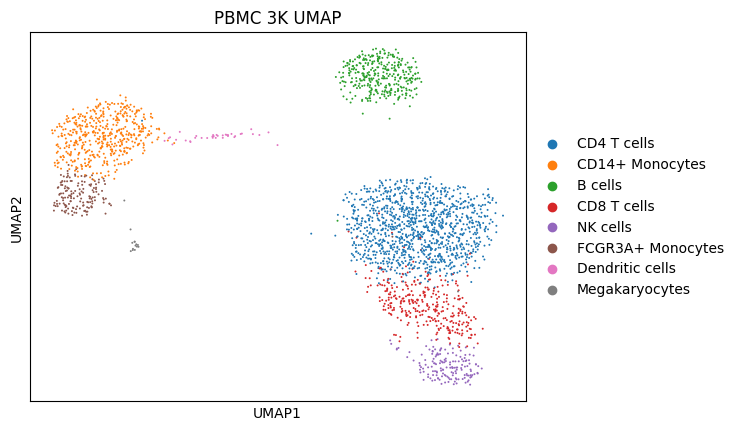

In [17]:
sc.pl.umap(
    adata,
    color="cell_type",
    size=8,
    title="PBMC 3K UMAP",
)

# Cell2Sentence Conversion

In this section, we will transform our AnnData object containing our single-cell dataset into a Cell2Sentence (C2S) dataset by calling the functions of the CSData class in the C2S code base. Full documentation for the functions of the CSData class can be found in the documentation page of C2S.

In [18]:
adata_obs_cols_to_keep = ["cell_type","organism"]

In [19]:
# Create CSData object
arrow_ds, vocabulary = cs.CSData.adata_to_arrow(
    adata=adata, 
    random_state=SEED, 
    sentence_delimiter=' ',
    label_col_names=adata_obs_cols_to_keep
)

100%|██████████| 2638/2638 [00:00<00:00, 17683.34it/s]


In [20]:
arrow_ds

Dataset({
    features: ['cell_name', 'cell_sentence', 'cell_type', 'organism'],
    num_rows: 2638
})

For this exercise we will consider the top 100 genes of the cell sentences

In [21]:
k = 100  # replace with your desired number of genes

arrow_ds = arrow_ds.map(lambda x: {"cell_sentence": " ".join(x["cell_sentence"].split()[:k])})

Map: 100%|██████████| 2638/2638 [00:00<00:00, 43846.84 examples/s]


In [22]:
sample_idx = 2000
len(arrow_ds[sample_idx]['cell_sentence'].split())

100

In [23]:
c2s_save_dir = "./c2s_api_testing"  # C2S dataset will be saved into this directory
c2s_save_name = "PBMC_3K_tutorial3"  # This will be the name of our C2S dataset on disk

In [24]:
cs_data = cs.CSData.csdata_from_arrow(
    arrow_dataset=arrow_ds, 
    vocabulary=vocabulary,
    save_dir=c2s_save_dir,
    save_name=c2s_save_name,
    dataset_backend="arrow"
)

Saving the dataset (1/1 shards): 100%|██████████| 2638/2638 [00:00<00:00, 450824.02 examples/s]


In [25]:
print(cs_data)

CSData Object; Path=./c2s_api_testing/PBMC_3K_tutorial3, Format=arrow


In [26]:
len(cs_data.get_sentence_strings())

2638

This time, we will leave off creating our CSData object until after we load our C2S model. This is because along with the model checkpoint, we saved the indices of train, val, and test set cells, which will allow us to select out test set cells for inference.

# Load C2S Model

Now, we will load a C2S model with which we will do cell type annotation. For this tutorial, this model will be the last checkpoint of the training session from <font color="red">tutorial notebook 4</font>, where we finetuned our cell type prediction model to do cell type prediction specifically on our immune tissue dataset. We will load the last checkpoint saved from training, and specify the same save_dir as we used before during training.
- <font color="red">Note:</font> If you are using your own data for this tutorial, make sure to switch out to the model checkpoint which you saved in tutorial notebook 3.
- If you want to annotate cell types without finetuning your own C2S model, then tutorial notebook 6 demonstrates how to load the C2S-Pythia-410M cell type prediction foundation model and use it to predict cell types without any finetuning.

We can define our CSModel object with our pretrained cell type prediction model as follows, specifying the same save_dir as we used in tutorial 3:

In [30]:
# Define CSModel object
cell_type_prediction_model_path = "./c2s_api_testing/csmodel_tutorial_3/2025-03-21-13_52_24_finetune_cell_type_prediction/checkpoint-330"

#save_dir = "/home/sr2464/palmer_scratch/C2S_Files_Syed/c2s_api_testing/csmodel_tutorial_3"
save_dir = "./c2s_api_testing/csmodel_tutorial_3"

save_name = "cell_type_pred_pythia_410M_2"
csmodel = cs.CSModel(
    model_name_or_path=cell_type_prediction_model_path,
    save_dir=save_dir,
    save_name=save_name
)

Using device: cuda


We will also load the data split indices saved alongside the C2S model checkpoint, so that we know which cells were part of the training and validation set. We will do inference on unseen test set cells, which are 10% of the original data.

In [31]:
base_path = "/".join(cell_type_prediction_model_path.split("/")[:-1])
print(cell_type_prediction_model_path)
print(base_path)

./c2s_api_testing/csmodel_tutorial_3/2025-03-21-13_52_24_finetune_cell_type_prediction/checkpoint-330
./c2s_api_testing/csmodel_tutorial_3/2025-03-21-13_52_24_finetune_cell_type_prediction


In [32]:
with open(os.path.join(base_path, 'data_split_indices_dict.pkl'), 'rb') as f:
    data_split_indices_dict = pickle.load(f)
data_split_indices_dict.keys()

dict_keys(['train', 'val', 'test'])

In [33]:
print(len(data_split_indices_dict["train"]))
print(len(data_split_indices_dict["val"]))
print(len(data_split_indices_dict["test"]))

2112
262
264


Select out test set cells from full arrow dataset

In [34]:
arrow_ds

Dataset({
    features: ['cell_name', 'cell_sentence', 'cell_type', 'organism'],
    num_rows: 2638
})

In [35]:
test_ds = arrow_ds.select(data_split_indices_dict["test"])
test_ds

Dataset({
    features: ['cell_name', 'cell_sentence', 'cell_type', 'organism'],
    num_rows: 264
})

Now, we will create our CSData object using only the test set cells:

In [36]:
#c2s_save_dir = "/home/sr2464/palmer_scratch/C2S_Files_Syed/c2s_api_testing"  # C2S dataset will be saved into this directory
c2s_save_dir = "./c2s_api_testing"  # C2S dataset will be saved into this directory

c2s_save_name = "PBMC_3K_tutorial4"  # This will be the name of our C2S dataset on disk

In [37]:
csdata = cs.CSData.csdata_from_arrow(
    arrow_dataset=test_ds, 
    vocabulary=vocabulary,
    save_dir=c2s_save_dir,
    save_name=c2s_save_name,
    dataset_backend="arrow"
)

Saving the dataset (1/1 shards): 100%|██████████| 264/264 [00:00<00:00, 98225.52 examples/s] 


In [38]:
print(csdata)

CSData Object; Path=./c2s_api_testing/PBMC_3K_tutorial4, Format=arrow


# Predict cell types

Now that we have loaded our finetuned cell type prediction model and have our test set, we will do cell type prediction inference using our C2S model. We can use the function predict_cell_types_of_data() from the tasks.py, which will take a CSModel() object and apply it to do cell type prediction on a CSData() object.

In [39]:
predicted_cell_types = predict_cell_types_of_data(
    csdata=csdata,
    csmodel=csmodel,
    n_genes=100
)

Reloading model from path on disk: ./c2s_api_testing/csmodel_tutorial_3/cell_type_pred_pythia_410M_2
Predicting cell types for 264 cells using CSModel...


100%|██████████| 264/264 [00:20<00:00, 12.64it/s]


In [40]:
len(predicted_cell_types)

264

In [41]:
predicted_cell_types[:3]

['CD4 T cells.', 'CD14+ Monocytes.', 'CD4 T cells.']

In [42]:
test_ds

Dataset({
    features: ['cell_name', 'cell_sentence', 'cell_type', 'organism'],
    num_rows: 264
})

In [43]:
total_correct = 0.0
for model_pred, gt_label in zip(predicted_cell_types, test_ds["cell_type"]):
    # C2S might predict a period at the end of the cell type, which we remove
    if model_pred[-1] == ".":
        model_pred = model_pred[:-1]
    
    if model_pred == gt_label:
        total_correct += 1

accuracy = total_correct / len(predicted_cell_types)

In [44]:
print("Accuracy:", accuracy)

Accuracy: 0.8295454545454546


In [45]:
for idx in range(0, 100, 10):
    print("Model pred: {}, GT label: {}".format(predicted_cell_types[idx], test_ds[idx]["cell_type"]))

Model pred: CD4 T cells., GT label: CD4 T cells
Model pred: CD8 T cells., GT label: CD4 T cells
Model pred: NK cells., GT label: NK cells
Model pred: CD14+ Monocytes., GT label: FCGR3A+ Monocytes
Model pred: B cells., GT label: CD4 T cells
Model pred: CD14+ Monocytes., GT label: FCGR3A+ Monocytes
Model pred: CD4 T cells., GT label: CD4 T cells
Model pred: CD4 T cells., GT label: CD4 T cells
Model pred: CD4 T cells., GT label: CD4 T cells
Model pred: CD4 T cells., GT label: CD4 T cells


We can see that our model achieves high accuracy, correctly predicting the cell type of unseen cells from the immune tissue data 83% of the time! The model learned to predict cell type annotations in natural language effectively from a short finetuning period on the new data.


[Go to Notebook 6 →](./6_Synthetic_Cell_Generation.ipynb) for some, well, advanced use cases like the generation of synthetic cells.